In [1]:
#!/usr/bin/env python

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from isoweek import Week
from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob

In [2]:
# Read the Danish data
df = pd.read_csv("data/DK_1958_1995_pseudofrac.csv", dtype=str)

df["value"] = pd.to_numeric(df["PseudoFrac"])

In [3]:
len(df['value'])

152

In [4]:
# Square-root transformed incidence proxy:
csv_files = glob.glob('stan_output/sinusoid_1958/*20250405185531*.csv')   


print(csv_files)

fit = from_csv(csv_files)

['stan_output/sinusoid_1958/sirs_1958_betafac_rhofac_sqrt-20250405185531_3.csv', 'stan_output/sinusoid_1958/sirs_1958_betafac_rhofac_sqrt-20250405185531_4.csv', 'stan_output/sinusoid_1958/sirs_1958_betafac_rhofac_sqrt-20250405185531_2.csv', 'stan_output/sinusoid_1958/sirs_1958_betafac_rhofac_sqrt-20250405185531_1.csv']


In [5]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [6]:
#for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho']:
for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'logrho']:
    print(f"{var}: {fit.stan_variable(var).mean()}")

S0: 0.5848642825
logx_I0: -2.1522591875
beta0: 8.747709458333334
dbeta: 0.12374587633333334
betaphase: 1.5546526166666668
sigma_obs: 0.008448888058333335
logrho: -0.32042816875


In [7]:
# Extract confidence intervals using arviz

import arviz as az

idata = az.from_cmdstanpy(fit)
for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho']:
    hpd = az.hdi(idata, var_names=[var], hdi_prob=0.95)

    print(f"{var}: {fit.stan_variable(var).mean()}" + "\t\t" + f"[{np.float64(hpd[var][0])} ; {np.float64(hpd[var][1])}]")
    if var=="delta":
        print(f"1/{var}: {(1/52)*1/fit.stan_variable(var).mean()} years" + "\t\t" + f"[{(1/52)*1/np.float64(hpd[var][1])} ; {(1/52)*1/np.float64(hpd[var][0])}]")

S0: 0.5848642825		[0.535568 ; 0.639622]
logx_I0: -2.1522591875		[-2.32534 ; -1.95476]
beta0: 8.747709458333334		[8.1767 ; 9.31294]
dbeta: 0.12374587633333334		[0.0967943 ; 0.151774]
betaphase: 1.5546526166666668		[1.36005 ; 1.76879]
sigma_obs: 0.008448888058333335		[0.00747179 ; 0.00948837]
rho: 0.47894405375		[0.428543 ; 0.535477]


beta0 posterior mean +- sd: 8.747709 +- 0.291040


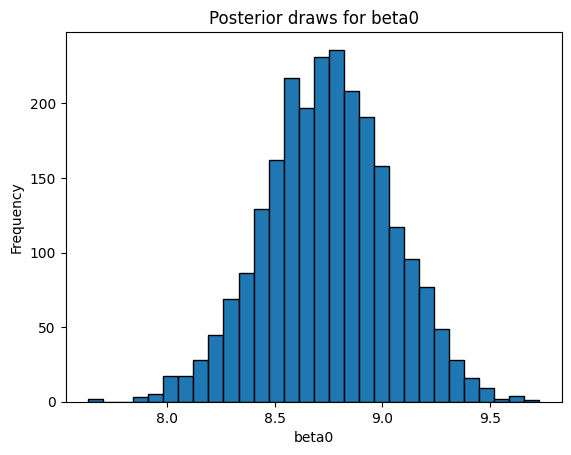

In [8]:
# Extract draws for variable:
#var = 'sigma_obs'
#var = 'rho'
var = 'beta0'
#var = 'betaphase'
#var = 'dbeta'
#var = 'delta'
#var = 'I0'
#var = 'S0'
#var = 'x_I0'
#var = 'logx_I0'
#var = 'T'




v_samples = fit.stan_variable(var)

mean_v = v_samples.mean()
sd_v = v_samples.std()

print(f"{var} posterior mean +- sd: {mean_v:.6f} +- {sd_v:.6f}")
if var=='delta':
    print(f"1/(mean({var})) = {1/mean_v:.3f} quarters = {(1/4)*1/mean_v:.3f} years")
    print(f"+ standard deviation: 1/(mean({var})) = {1/(mean_v+sd_v):.3f} quarters = {(1/4)*1/(mean_v+sd_v):.3f} years")
    print(f"- standard deviation: 1/(mean({var})) = {1/(mean_v-sd_v):.3f} quarters = {(1/4)*1/(mean_v-sd_v):.3f} years")

plt.hist(v_samples, bins=30, edgecolor='k')
plt.title("Posterior draws for " + var)
plt.xlabel(var)
plt.ylabel("Frequency")
plt.show()


156
0.47894405375


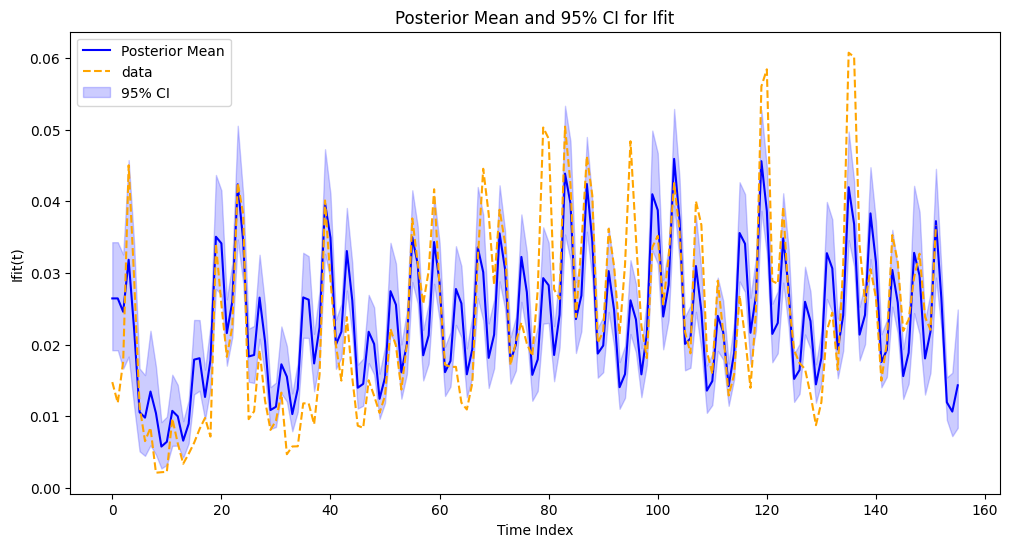

In [9]:
#var = "beff"
#var = "rheff"
var = "Ifit"

sqrt_transform = True

# Square root transform:
dat = df["value"]
if sqrt_transform:
    pretransform_mean = df["value"].mean()
    dat = np.sqrt(dat)
    dat = dat * pretransform_mean/dat.mean()

v_draws = fit.stan_variable(var)
print(v_draws.shape[1])

############

mean_v = np.mean(v_draws, axis=0)  # average over draws
lower_v = np.percentile(v_draws, 2.5, axis=0)  # 2.5% quantile
upper_v = np.percentile(v_draws, 97.5, axis=0) # 97.5% quantile


time_idx = np.arange(0, v_draws.shape[1] )  # 1..(N+Npred)

plt.figure(figsize=(12, 6))
plt.plot(time_idx, mean_v, label='Posterior Mean', color='blue')

print(np.mean(fit.stan_variable("rho")))


plt.plot(dat, "--", label="data", color='orange')

plt.fill_between(time_idx, lower_v, upper_v, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time Index')
plt.ylabel(var + '(t)')
plt.title('Posterior Mean and 95% CI for ' + var)
plt.legend()


plt.show()


156


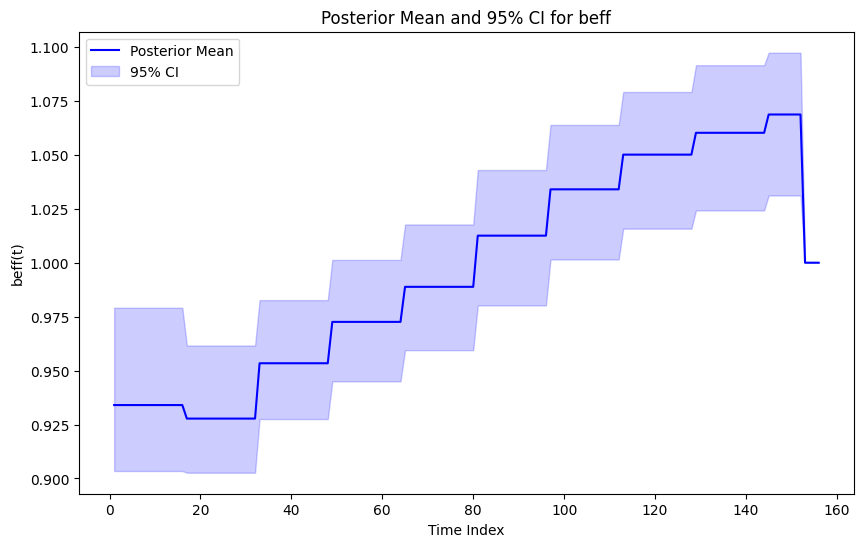

In [10]:
var = "beff"

v_draws = fit.stan_variable(var)
print(v_draws.shape[1])

############

mean_v = np.mean(v_draws, axis=0)  # average over draws
lower_v = np.percentile(v_draws, 2.5, axis=0)  # 2.5% quantile
upper_v = np.percentile(v_draws, 97.5, axis=0) # 97.5% quantile

time_idx = np.arange(1, v_draws.shape[1] + 1)  # 1..(N+Npred)

plt.figure(figsize=(10, 6))
plt.plot(time_idx, mean_v, label='Posterior Mean', color='blue')

plt.fill_between(time_idx, lower_v, upper_v, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time Index')
plt.ylabel(var + '(t)')
plt.title('Posterior Mean and 95% CI for ' + var)
plt.legend()

plt.show()


# Per-chain time-series:

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#var = "I"
var = "Ifit"
#var = "beta"

S_draws_all = fit.stan_variable(var)

num_chains = fit.chains

draws_per_chain = S_draws_all.shape[0] // num_chains

S_draws_per_chain = S_draws_all.reshape(
    (num_chains, draws_per_chain, S_draws_all.shape[1])
)


156
Max of chain 1: 0.04608980983333333 (multiplied by 6e6: 276539.0)
Max of chain 2: 0.0457967505 (multiplied by 6e6: 274781.0)
Max of chain 3: 0.04592814416666667 (multiplied by 6e6: 275569.0)
Max of chain 4: 0.045856256500000005 (multiplied by 6e6: 275138.0)


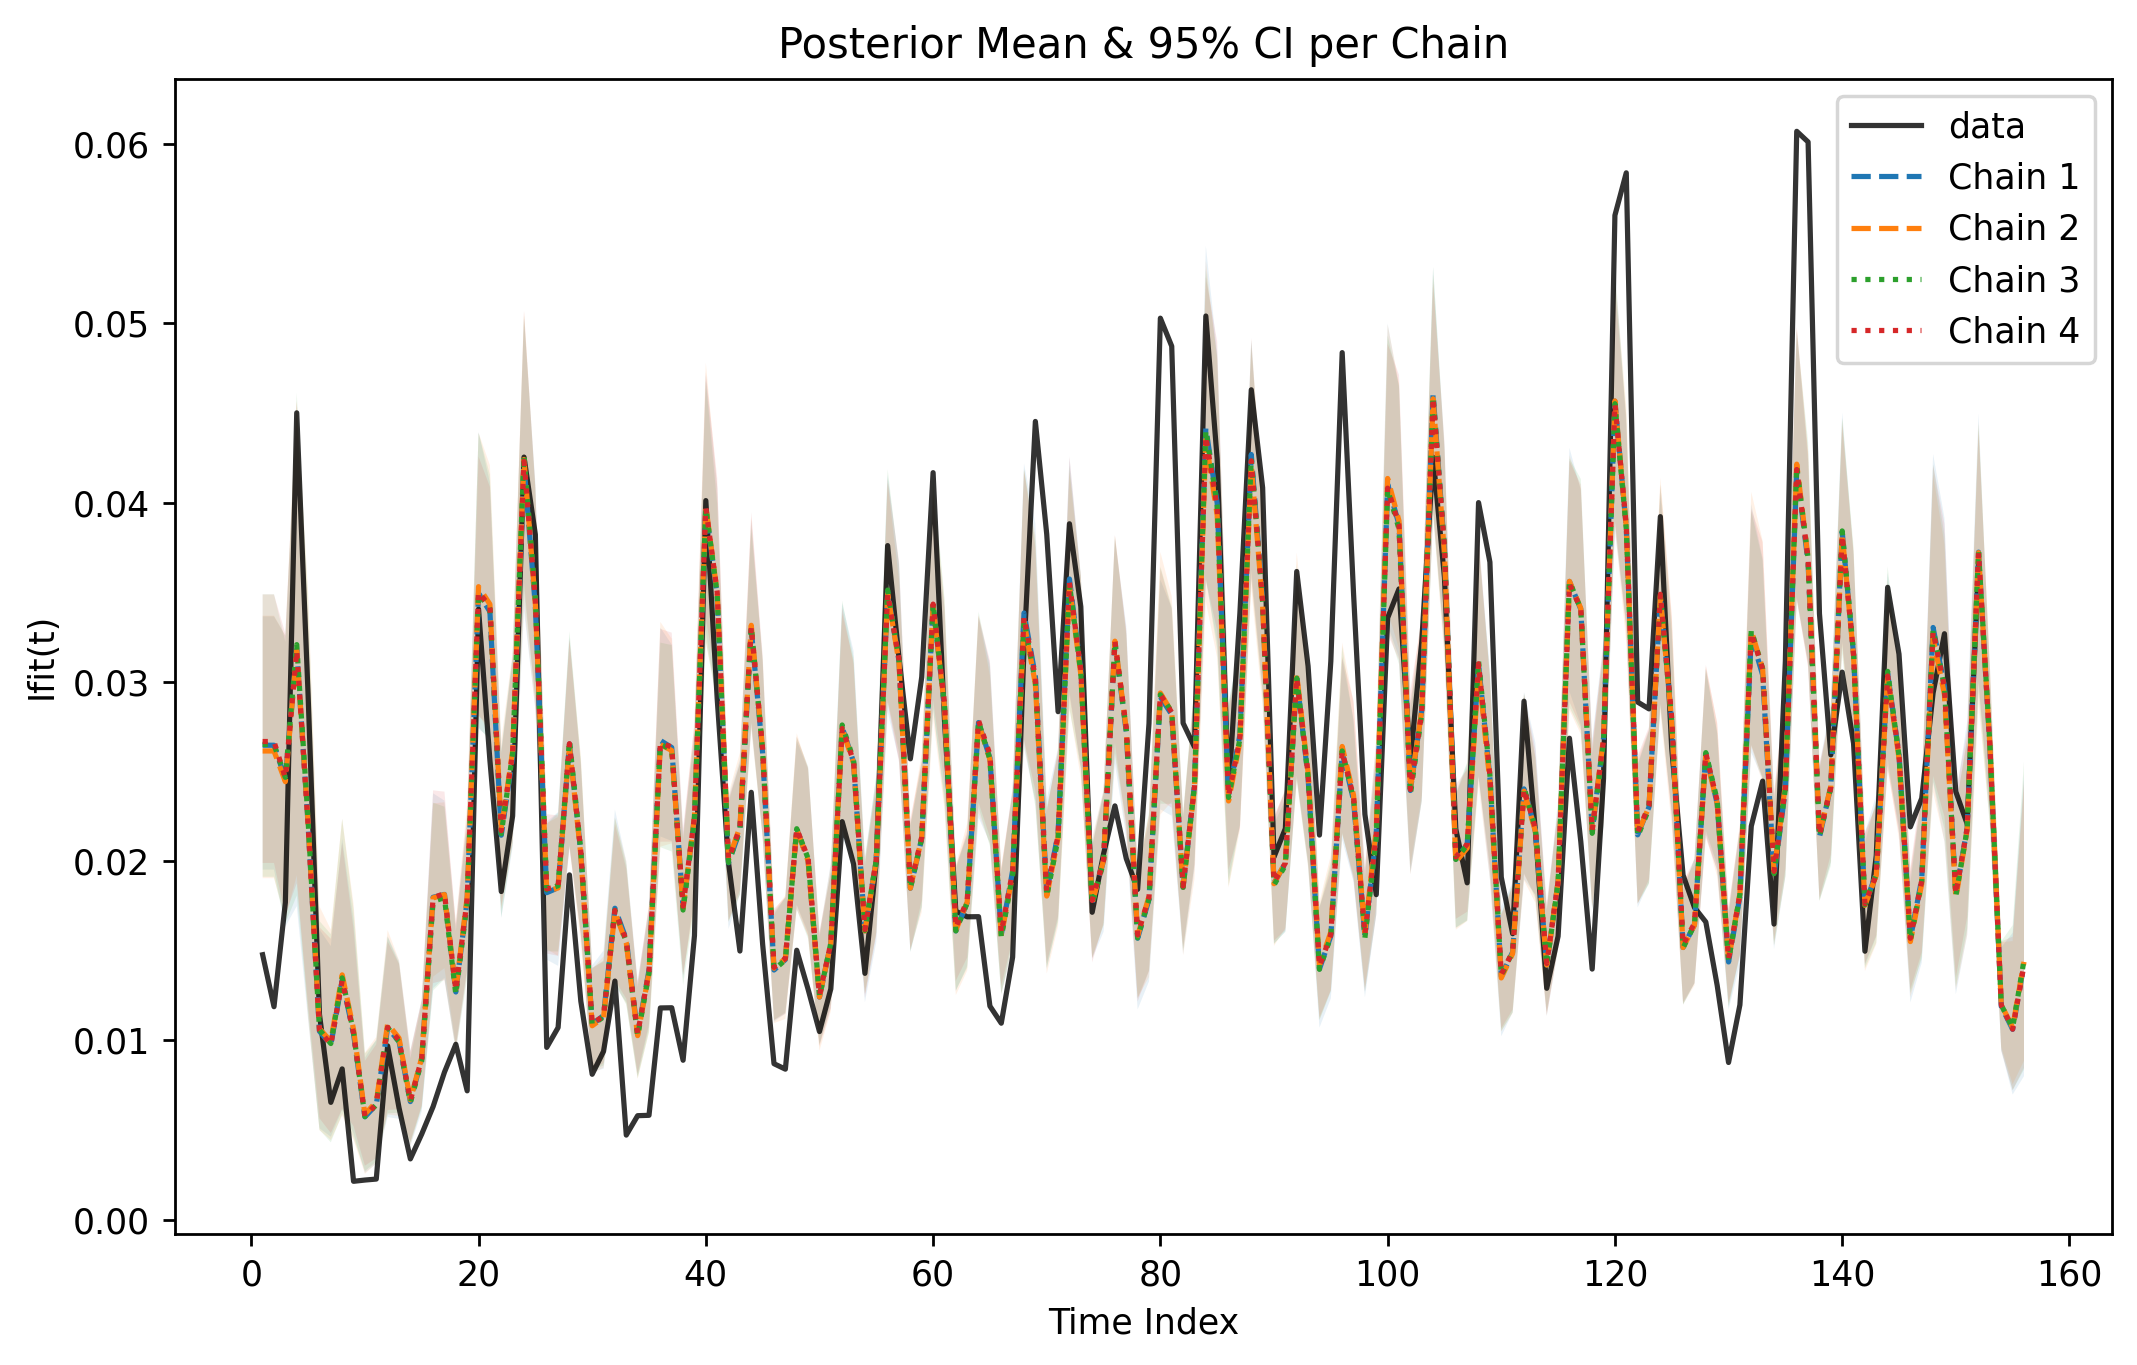

In [12]:
time_idx = np.arange(1, S_draws_per_chain.shape[2] + 1)

plt.figure(figsize=(10, 6), dpi=250)

plot_data = True

excluded_chains = []
#excluded_chains = [1,3,2]


if plot_data:
    # Square root transform:
    dat = df["value"]
    if sqrt_transform:
        pretransform_mean = df["value"].mean()
        dat = np.sqrt(dat)
        dat = dat * pretransform_mean/dat.mean()
    
    v_draws = fit.stan_variable(var)
    print(v_draws.shape[1])
    plt.plot(time_idx[:-4], dat, label="data", color='black', alpha=0.8)

for c in range(num_chains):
    if not (c+1 in excluded_chains):
        chain_data = S_draws_per_chain[c, :, :]  # shape: (draws_per_chain, time_points)
        chain_mean = chain_data.mean(axis=0)
        chain_lower = np.percentile(chain_data, 2.5, axis=0)
        chain_upper = np.percentile(chain_data, 97.5, axis=0)
        print(f"Max of chain {c+1}: {np.max(chain_mean)} (multiplied by 6e6: {np.round(np.max(chain_mean)*6e6)})")
    
        if c+1 <= num_chains/2:
            plt.plot(time_idx, chain_mean, "--", label=f'Chain {c+1}')
        else:
            plt.plot(time_idx, chain_mean, ":", label=f'Chain {c+1}')
        plt.fill_between(time_idx, chain_lower, chain_upper, alpha=0.1)

plt.xlabel("Time Index")
plt.ylabel(f"{var}(t)")
plt.title("Posterior Mean & 95% CI per Chain")
plt.legend()

In [13]:
df["year"] = pd.to_numeric(df["year"])
df["quarter"] = pd.to_numeric(df["quarter"])
df["month"] = 3*(df["quarter"]-1)+1
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

1958-01-01 00:00:00
[Timestamp('1958-01-01 00:00:00'), Timestamp('1962-01-01 00:00:00'), Timestamp('1966-01-01 00:00:00'), Timestamp('1970-01-01 00:00:00'), Timestamp('1974-01-01 00:00:00'), Timestamp('1978-01-01 00:00:00'), Timestamp('1982-01-01 00:00:00'), Timestamp('1986-01-01 00:00:00'), Timestamp('1990-01-01 00:00:00'), Timestamp('1994-01-01 00:00:00'), Timestamp('1996-01-01 00:00:00')]


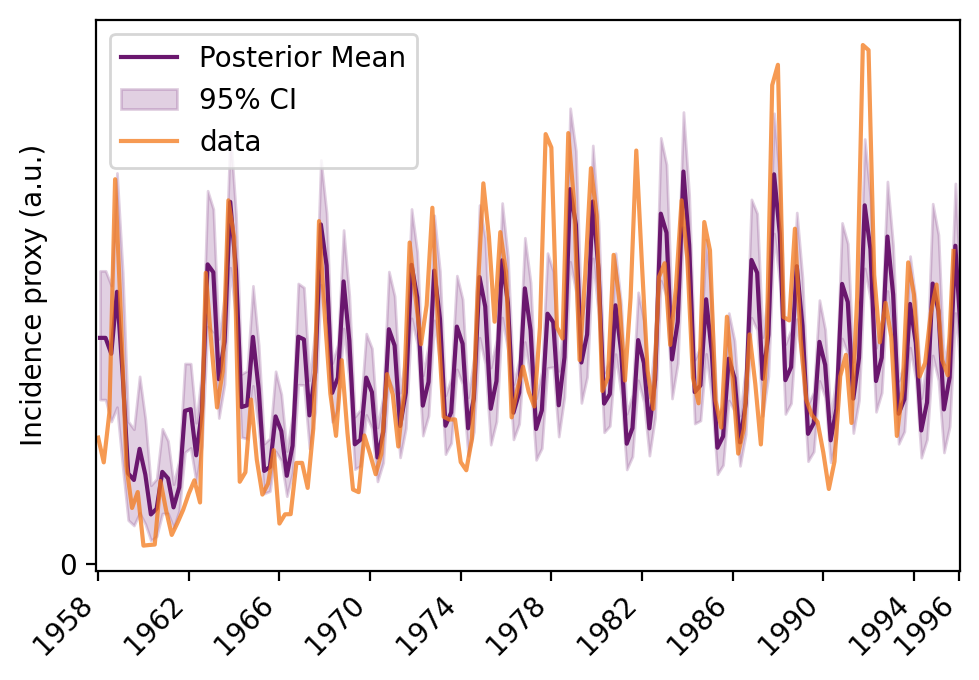

In [14]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

start_date = df["date"].iloc[0]
print(start_date)
n_time_points = v_draws.shape[1]
time_axis = pd.date_range(start=start_date, periods=n_time_points, freq="3ME")

sqrt_transform = True

# Square root transform:
dat = df["value"]
if sqrt_transform:
    pretransform_mean = df["value"].mean()
    dat = np.sqrt(dat)
    dat = dat * pretransform_mean/dat.mean()

mean_v = np.mean(v_draws, axis=0)
lower_v = np.percentile(v_draws, 2.5, axis=0)
upper_v = np.percentile(v_draws, 97.5, axis=0)

plt.figure(figsize=(5, 3.5), dpi=200)
plt.plot(time_axis, mean_v, label='Posterior Mean', color=plt.cm.inferno(0.3))
plt.fill_between(time_axis, lower_v, upper_v, color=plt.cm.inferno(0.3), alpha=0.2, label='95% CI')

plt.plot(df["date"], dat, "-", label="data", color=plt.cm.inferno(0.7), alpha=0.75)


ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

my_xticks = []
curr_date = pd.to_datetime("1958.1.1")
my_xticks.append(curr_date)

curr_date_int = 1962
curr_date = pd.to_datetime(str(curr_date_int) + ".1") 
while curr_date < time_axis[-1]:
    my_xticks.append(curr_date)
    curr_date_int += 4
    curr_date = pd.to_datetime(str(curr_date_int))

curr_date_int -= 2
curr_date = pd.to_datetime(str(curr_date_int))
my_xticks.append(curr_date)
print(my_xticks)

plt.xticks(my_xticks)
#plt.yticks([])
plt.yticks([0])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")


plt.ylabel("Incidence proxy (a.u.)")

plt.legend()
plt.tight_layout()

plt.xlim([start_date - pd.to_timedelta(30, unit='D'), df["date"].iloc[-1] + pd.to_timedelta(105, unit='D') ])

plt.show()


In [15]:
chain_of_interest = 4
df_draws = fit.draws_pd()

#for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'logrho', 'delta']:
for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'logrho']:
    c = chain_of_interest-1
    chain_subset = df_draws.iloc[c*draws_per_chain:(c+1)*draws_per_chain]
    mm = np.mean(chain_subset[var].values)
    print(f"{var}: {mm}")
    if var == "logx_I0":
        print(f"\t(I0 = {10**mm * np.mean(chain_subset["S0"].values)})")

S0: 0.5849378749999999
logx_I0: -2.14992005
	(I0 = 0.004141805429062749)
beta0: 8.7392927
dbeta: 0.123041557
betaphase: 1.5491094
sigma_obs: 0.00843880225
logrho: -0.3208198566666667


# Pairwise posterior plots

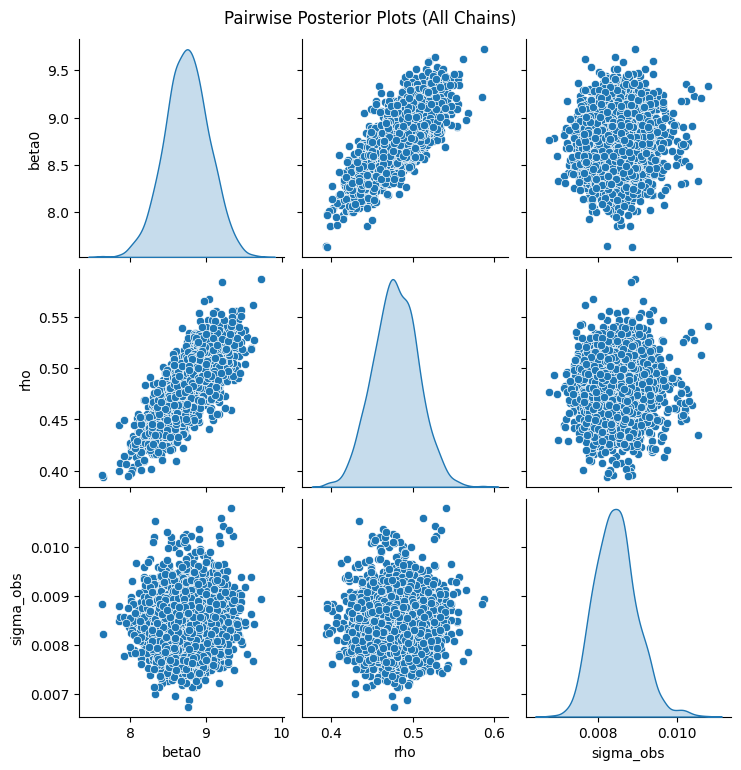

In [16]:
df_draws = fit.draws_pd()

params_of_interest = ["beta0", "rho", "sigma_obs"]  # whatever parameters you want

df_subset = df_draws[params_of_interest]

sns.pairplot(df_subset, diag_kind="kde")
plt.suptitle("Pairwise Posterior Plots (All Chains)", y=1.02)
plt.show()


In [17]:
# Per-chain

In chain 1, averages were: beta0 : 8.765498816666668,   rho : 0.48018823  (mean product: 4.2156042783253005)


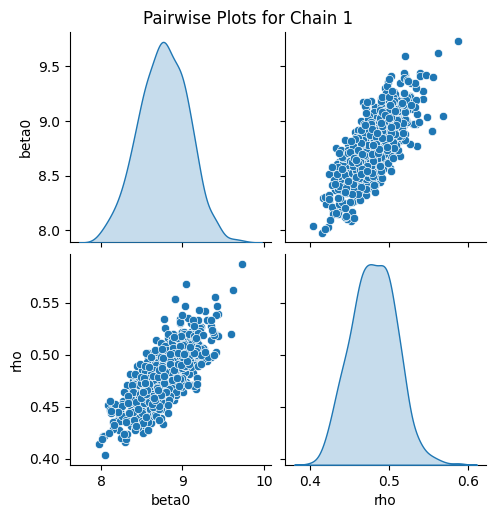

In chain 2, averages were: beta0 : 8.732036616666667,   rho : 0.4777128833333334  (mean product: 4.177696457829167)


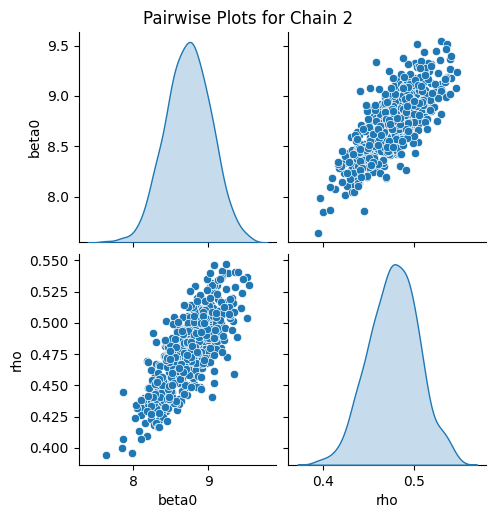

In chain 3, averages were: beta0 : 8.7540097,   rho : 0.4793481699999999  (mean product: 4.2018995987834495)


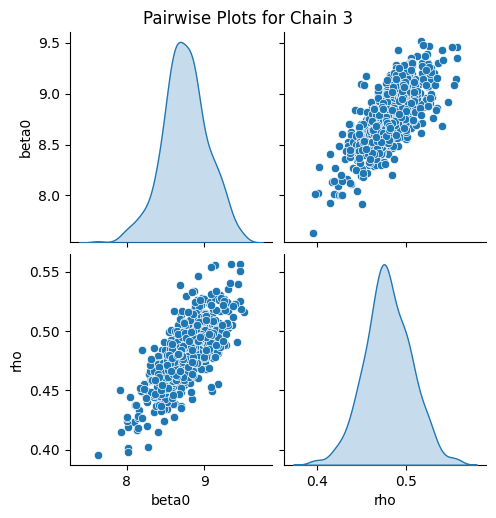

In chain 4, averages were: beta0 : 8.7392927,   rho : 0.4785269316666667  (mean product: 4.1874680715018835)


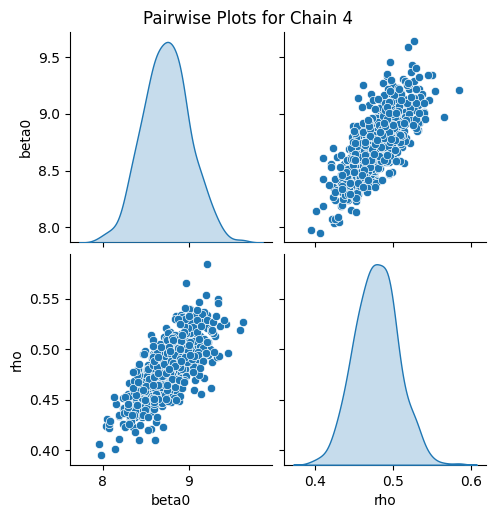

In [18]:
#params_of_interest = ["sigma_obs", "rho"]
#params_of_interest = ["S0", "I0"]
#params_of_interest = ["delta", "beta0"]
#params_of_interest = ["T", "delta"]
#params_of_interest = ["betaphase", "delta"]
params_of_interest = ["beta0", "rho"]

for c in range(num_chains):
    chain_subset = df_draws.iloc[c*draws_per_chain:(c+1)*draws_per_chain]
    # chain_subset now holds rows for chain c
    p1 = params_of_interest[0]
    p2 = params_of_interest[1]
    mp = np.mean(chain_subset[params_of_interest[0]].values*chain_subset[params_of_interest[1]].values)
    print(f"In chain {c+1}, averages were: {params_of_interest[0]} : {chain_subset[params_of_interest[0]].mean()},   {params_of_interest[1]} : {chain_subset[params_of_interest[1]].mean()}  (mean product: {mp})")
    for p in [p1, p2]:
        if p in ["delta"]:
            print(f"1/{p} = {1/np.mean(chain_subset[p].values)}")
    sns.pairplot(chain_subset[params_of_interest], diag_kind="kde")
    plt.suptitle(f"Pairwise Plots for Chain {c+1}", y=1.02)
    plt.show()
